In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.optim as optim

from torch.distributions import Independent, Uniform

import matplotlib.pyplot as plt

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# SLCP experiment

In [4]:
from simulators import SLCP
from datasets import LTEDataset
from models import Flatten, MLP, MNRE
from criterions import MNRELoss
from samplers import TractableSampler, NRESampler

## Simulator 

In [5]:
simulator = SLCP().to(device)
simulator.sample()

(tensor([-2.0081, -1.9753, -2.7935, -2.8652, -2.6013], device='cuda:0'),
 tensor([[ -7.6989,   2.4847],
         [  6.9504, -11.6552],
         [-10.2977,   5.6007],
         [-12.4941,   7.7435]], device='cuda:0'))

### Dataset

In [6]:
subsets = torch.eye(5).bool()
subsets

tensor([[ True, False, False, False, False],
        [False,  True, False, False, False],
        [False, False,  True, False, False],
        [False, False, False,  True, False],
        [False, False, False, False,  True]])

In [7]:
joint_subsets = []

for i in range(5):
    for j in range(i, 5):
        joint_subsets.append(torch.logical_or(subsets[i], subsets[j]))
    
joint_subsets = torch.stack(joint_subsets)
joint_subsets

tensor([[ True, False, False, False, False],
        [ True,  True, False, False, False],
        [ True, False,  True, False, False],
        [ True, False, False,  True, False],
        [ True, False, False, False,  True],
        [False,  True, False, False, False],
        [False,  True,  True, False, False],
        [False,  True, False,  True, False],
        [False,  True, False, False,  True],
        [False, False,  True, False, False],
        [False, False,  True,  True, False],
        [False, False,  True, False,  True],
        [False, False, False,  True, False],
        [False, False, False,  True,  True],
        [False, False, False, False,  True]])

In [8]:
trainset = LTEDataset(simulator, joint_subsets.to(device))

## Model

In [9]:
model = MNRE(masks=joint_subsets, encoder=Flatten((4, 2)), num_layers=6, hidden_size=128).to(device)
criterion = MNRELoss(masks=joint_subsets).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, amsgrad=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=1e-1, patience=5, threshold=1e-2, verbose=True)

In [10]:
model.train()

epoch = 0
epoch_size = 256

losses = []

for thetas, xs, mask in trainset:    
    ratios = model(thetas, xs)
    loss = criterion(ratios, mask)

    losses.append(loss.tolist())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if len(losses) == epoch_size:
        losses = torch.tensor(losses)
        
        print(f'{epoch}: {losses.mean()} +- {losses.std()}')
        scheduler.step(losses.mean())
        
        epoch += 1
        losses = []
    
        if optimizer.param_groups[0]['lr'] < 1e-5:
            break

0: 6.415827751159668 +- 0.736964225769043
1: 5.724719047546387 +- 0.6197754144668579
2: 5.330848693847656 +- 0.559901237487793
3: 5.124746799468994 +- 0.5638678669929504
4: 4.956254005432129 +- 0.5445237755775452
5: 4.824827194213867 +- 0.5088298916816711
6: 4.728626251220703 +- 0.4947717785835266
7: 4.723959445953369 +- 0.5174713134765625
8: 4.561919212341309 +- 0.4836078882217407
9: 4.448784828186035 +- 0.45901772379875183
10: 4.4735283851623535 +- 0.48226046562194824
11: 4.38935661315918 +- 0.483583927154541
12: 4.367692947387695 +- 0.47742947936058044
13: 4.257144451141357 +- 0.4575884938240051
14: 4.268566131591797 +- 0.44641122221946716
15: 4.230253219604492 +- 0.4471539855003357
16: 4.250669956207275 +- 0.4938426613807678
17: 4.15351676940918 +- 0.42806190252304077
18: 4.196101188659668 +- 0.45207127928733826
19: 4.132606506347656 +- 0.4601335823535919
20: 4.130829811096191 +- 0.45046401023864746
21: 4.108773231506348 +- 0.42710745334625244
22: 4.079009056091309 +- 0.43429008126

In [11]:
model.eval()

MNRE(
  (encoder): Flatten()
  (nres): ModuleList(
    (0): NRE(
      (0): Flatten()
      (1): Linear(in_features=9, out_features=128, bias=True)
      (2): PReLU(num_parameters=128)
      (3): Identity()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): PReLU(num_parameters=128)
      (6): Identity()
      (7): Linear(in_features=128, out_features=128, bias=True)
      (8): PReLU(num_parameters=128)
      (9): Identity()
      (10): Linear(in_features=128, out_features=128, bias=True)
      (11): PReLU(num_parameters=128)
      (12): Identity()
      (13): Linear(in_features=128, out_features=128, bias=True)
      (14): PReLU(num_parameters=128)
      (15): Identity()
      (16): Linear(in_features=128, out_features=128, bias=True)
      (17): PReLU(num_parameters=128)
      (18): Identity()
      (19): Linear(in_features=128, out_features=128, bias=True)
      (20): PReLU(num_parameters=128)
      (21): Identity()
      (22): Linear(in_features=128, out_fea

## Metropolis-Hastings

In [12]:
theta_star = torch.tensor([0.7, -2.9, -1., -0.9,  0.6]).to(device)
x_star = simulator(theta_star)
x_star

tensor([[ 2.0442, -1.4689],
        [ 0.3230, -3.4761],
        [-0.5477, -3.4889],
        [ 0.2810, -3.1008]], device='cuda:0')

In [13]:
x_star = x_star.expand((1024,) + x_star.shape)

### Likelihood

In [14]:
sampler = TractableSampler(simulator, x_star)

thetas = sampler(1024)
thetas = torch.cat(thetas).numpy()

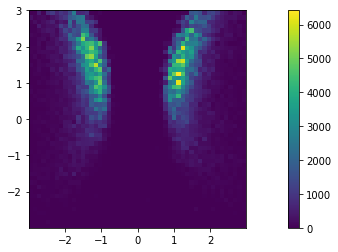

In [15]:
plt.hist2d(thetas[:, 2], thetas[:, 4], (50, 50))
plt.colorbar()
plt.axis('square')
plt.show()

### Likelihood-free

In [16]:
z_star = model.encoder(x_star)

In [17]:
mask, nre = model[11]
prior = Independent(Uniform(simulator.low[mask], simulator.high[mask]), 1)

In [18]:
sampler = NRESampler(prior, nre, z_star)

thetas = sampler(512)
thetas = torch.cat(thetas).numpy()

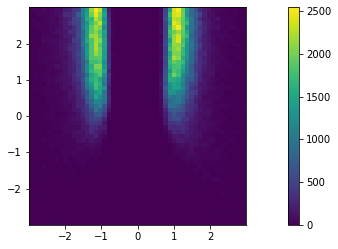

In [19]:
plt.hist2d(thetas[:, 0], thetas[:, 1], (50, 50))
plt.colorbar()
plt.axis('square')
plt.show()